In [ ]:
import pandas as pd
import keras
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
from keras.models import Sequential
from keras.layers import Embedding, Conv1D, MaxPooling1D, GlobalMaxPooling1D, Dense
import numpy as np
from sklearn.model_selection import train_test_split
from keras.utils import to_categorical
from sklearn.metrics import confusion_matrix, accuracy_score, precision_score, recall_score, f1_score
from tensorflow.keras.layers import Dropout
import nltk
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from nltk.stem import PorterStemmer

nltk.download('punkt')
nltk.download('stopwords')
import re
from sklearn.metrics import confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt
from tensorflow.keras.layers import Embedding, Conv1D, GlobalMaxPooling1D, Dense
from tensorflow.keras.models import Sequential


Mounted at /content/drive


[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


**Načítanie datasetov**

---


 train: Twitter dataset by Davidson (80%, s podvzorkovanim);
 test: Twitter dataset by Davidson (20%)

In [ ]:

train = pd.read_csv('train.csv')
test = pd.read_csv('test.csv')


**Predspracovanie dat**

---



In [ ]:
# Načítanie stop-slov pre anglický jazyk
stopwords = nltk.corpus.stopwords.words("english")
# Rozšírenie stop-slov o termíny charakteristické pre Twitter
other_exclusions = ["#ff", "ff", "rt"]
stopwords.extend(other_exclusions)
# Inicializácia stemmera
stemmer = PorterStemmer()

def preprocess(tweet):
     # Odstránenie nadbytočných medzier na začiatku spracovania
    tweet_space = tweet.str.replace(r'\s+', ' ', regex=True)

    # Odstránenie používateľských spomenutí (učtov)
    tweet_name = tweet_space.str.replace(r'@[\w\-]+', '', regex=True)

    # Odstránenie odkazov
    giant_url_regex =  re.compile('http[s]?://(?:[a-zA-Z]|[0-9]|[$-_@.&+]|'
            '[!*\(\),]|(?:%[0-9a-fA-F][0-9a-fA-F]))+')
    tweets = tweet_name.str.replace(giant_url_regex, '', regex=True)

    # Odstránenie interpunkcie a čísel
    punc_remove = tweets.str.replace("[^a-zA-Z]", " ", regex=True)

    # Opätovné odstránenie nadbytočných medzier po odstránení interpunkcie a čísel
    newtweet = punc_remove.str.replace(r'\s+', ' ', regex=True)

    # Konverzia na malé písmená
    tweet_lower = newtweet.str.lower()

    # Tokenizácia
    tokenized_tweet = tweet_lower.apply(lambda x: x.split())

    # Odstránenie stop-slov a stemming
    tokenized_tweet = tokenized_tweet.apply(lambda x: [stemmer.stem(i) for i in x if i not in stopwords])

    # Spojenie tokenov do reťazca
    tokenized_tweet = tokenized_tweet.apply(lambda x: ' '.join(x))

    return tokenized_tweet


In [ ]:
# Odstránenie stĺpca 'class' z train
train_texts = train.drop('class', axis=1)

# Konverzia stĺpca 'class' na kategóriálny formát
train_labels = to_categorical(train['class'], num_classes=2)

# Odstránenie stĺpca 'class' z test
test_texts = test.drop('class', axis=1)

# Konverzia stĺpca 'class' na kategóriálny formát
test_labels = to_categorical(test['class'], num_classes=2)


In [ ]:
# Aplikácia funkcie preprocess na train_texts a test_texts
train_texts['tweet'] = preprocess(train_texts['tweet'])

test_texts['tweet'] = preprocess(test_texts['tweet'])


**CNN**

---
Parametre modelu

In [ ]:

VOCAB_SIZE = 10000
MAX_LENGTH = 734
EMBEDDING_DIM = 200
FILTERS = 256
KERNEL_SIZE = 5
HIDDEN_UNITS = 128
tokenizer = Tokenizer(num_words=VOCAB_SIZE)
tokenizer.fit_on_texts(train_texts['tweet'])
# Príprava textových komentárov na numerické sekvencie pomocou tokenizeru.
sequences = tokenizer.texts_to_sequences(train_texts['tweet'])

# Zarovnanie numerických sekvencií na maximálnu dĺžku, ktorú určuje MAX_LENGTH.
data = pad_sequences(sequences, maxlen=MAX_LENGTH)

In [ ]:
# Vytvorenie sekvenčného modelu
model = Sequential()

# Pridanie vrstvy embeddingu na mapovanie slov na vektory a určenie vstupnej dĺžky sekvencií
model.add(Embedding(VOCAB_SIZE, EMBEDDING_DIM, input_length=MAX_LENGTH))

# Pridanie vrstvy dropout na redukciu pretrénovania
model.add(Dropout(0.5))

# Pridanie konvolučnej vrstvy s RELU aktiváciou na extrakciu rôznych charakteristík z textu
model.add(Conv1D(FILTERS, KERNEL_SIZE, activation='relu'))

# Pridanie vrstvy max-poolingu na získanie najvýznamnejších charakteristík
model.add(MaxPooling1D(pool_size=2))

# Pridanie vrstvy global max-poolingu na extrakciu najvýznamnejšej črty zo všetkých čŕt
model.add(GlobalMaxPooling1D())

# Pridanie skrytej vrstvy s RELU aktiváciou
model.add(Dense(HIDDEN_UNITS, activation='relu'))

# Pridanie výstupnej vrstvy s aktiváciou sigmoid pre binárnu klasifikáciu
model.add(Dense(2, activation='sigmoid'))

# Kompilácia modelu s Adam optimizerom, binárnou krížovou entropiou ako stratovou funkciou a metrikou presnosti
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

# Trénovanie modelu na trénovacích dátach s definovanou veľkosťou batcha, počtom epoch a rozdelením na validačnú sadu
model.fit(data, np.array(train_labels), batch_size=64, epochs=10, validation_split=0.1)


In [ ]:
# Príprava textových komentárov na numerické sekvencie pomocou tokenizeru.
sequences_test = tokenizer.texts_to_sequences(test_texts['tweet'])
# Zarovnanie numerických sekvencií na maximálnu dĺžku, ktorú určuje MAX_LENGTH.
data_test = pad_sequences(sequences_test, maxlen=MAX_LENGTH)

# Vyhodnotenie modelu na testovacom súbore údajov
loss, accuracy = model.evaluate(data_test, test_labels, verbose=1)
print("Test Accuracy:", accuracy)


155/155 [==============================] - 1s 6ms/step - loss: 0.3420 - accuracy: 0.9292
Test Accuracy: 0.9291910529136658


In [ ]:
# Predikcia pre testovacie dáta
predictions = model.predict(data_test)

predicted_classes = np.argmax(predictions, axis=1)

# Vytvorenie DataFrame s skutočnými triedami a predikovanými triedami
results_df = pd.DataFrame({
    'Text': test_texts['tweet'],
    'True Class': np.argmax(test_labels, axis=1),
    'Predicted Class': predicted_classes
})


155/155 [==============================] - 1s 5ms/step


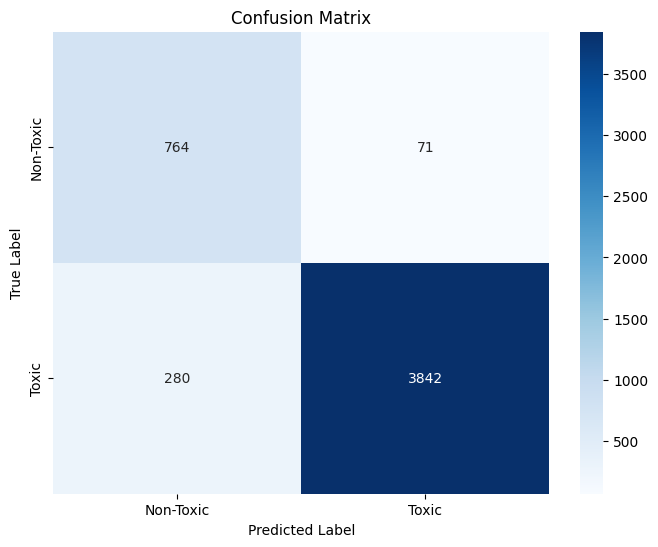

In [ ]:
# Vytvorenie confusion matrix
conf_matrix = confusion_matrix(np.argmax(test_labels, axis=1), predicted_classes)

# Nastavenie popisov
labels = ['True Negative', 'False Positive', 'False Negative', 'True Positive']
categories = ['Non-Toxic', 'Toxic']

# Vytvorenie DataFrame pre confusion matrix s popismi
conf_df = pd.DataFrame(conf_matrix, index=categories, columns=categories)

# Vizualizácia confusion matrix pomocou teplotnej mapy
plt.figure(figsize=(8, 6))
sns.heatmap(conf_df, annot=True, fmt='d', cmap='Blues')
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.title('Confusion Matrix')
plt.show()


In [ ]:
def false_negative_rate(false_negatives, true_positives):
    return false_negatives / (false_negatives + true_positives)
# Vypočítanie falošných negatív
false_negatives = conf_matrix[1][0]
print(false_negatives)
# Vypočítanie počtu skutočných pozitív
true_positives = conf_matrix[1][1]
print(true_positives)
# Výpočet falošnej negatívnej miery
fnr = false_negative_rate(false_negatives, true_positives)

print("Falošná negatívna miera:", fnr)

280
3842
Falošná negatívna miera: 0.06792819019893255
